<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Fenics_tutorial_PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

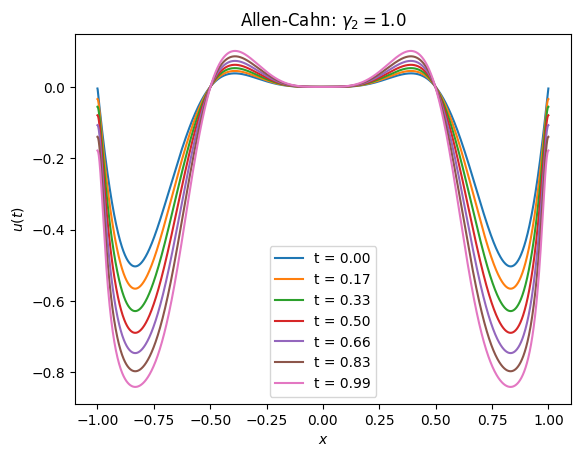

In [55]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#https://fenicsproject.discourse.group/t/periodic-boundary-conditions-for-allen-cahn/4452
# parameters
#####################################
nx       = 1000        # mesh points
theta    = 0.5         # time discretization
dt       = 5.0e-3      # time step
(x0, xf) = (-1.0, 1.0) # boundaries
order    = 2           # mesh polynomial order

# Class for interfacing with the Newton solver
class AllenCahnEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)

# formulate problem
#####################################
# create periodic boundary condition
pbc = PeriodicBoundary()

# setup mesh
mesh = IntervalMesh(nx, x0, xf)
V = FunctionSpace(mesh, "CG", order, constrained_domain=pbc)

# define test & trial functions
du = TrialFunction(V)
v = TestFunction(V)

# define functions
u = Function(V)
u0 = Function(V)

# initial conditions
u_init = Expression("pow(x[0],2)*sin(2*pi*x[0])", degree=2)
u.interpolate(u_init)
u0.interpolate(u_init)

mu_mid = (1.0-theta)*u0 + theta*u
gamma1 = 0.0001
gamma2 = 1.0 # {1 (easiest):4 (hardest)}

F = u*v*dx - u0*v*dx +                    \
    dt*gamma1*dot(grad(u), grad(v))*dx +  \
    dt*gamma2*(u**3 - u)*v*dx

J = derivative(F, u, du)

problem = AllenCahnEquation(J, F)
solver = NewtonSolver()

# map mesh vertices to solution DOFs
#####################################
dof_coordinates = V.tabulate_dof_coordinates()

# get indicies of sorted result
dofs      = np.squeeze(dof_coordinates)
asc_order = np.argsort(dofs)

# time stepping
#####################################
(t, T) = (0.0, 1.0)

plt.figure
plt.title(f"Allen-Cahn: $\gamma_2={gamma2}$")
plt.ylabel("$u(t)$")
plt.xlabel("$x$")
labels = []

while t < T:

    # compute current solution
    solver.solve(problem, u.vector())

    # update previous solution
    u0.vector()[:] = u.vector()

    # plot 6 solution snapshots
    if round(t/dt) % round(T/dt/6) == 0:
        plt.plot(dofs[asc_order], u.vector()[asc_order])
        labels.append(f"t = {t/T:.2f}")

    # increment time
    t += dt
    n += 1

plt.legend(labels)
plt.show()

In [29]:
try :
    from google.colab import files
except:
    pass
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

import matplotlib.pyplot as plt;
import numpy as np;
import time
%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'
!dolfin-version
import sys, os, sympy, shutil, math
%matplotlib inline
parameters["form_compiler"].update({"optimize": True, "cpp_optimize": True,
                                 "representation":"uflacs", "quadrature_degree": 2})

2019.2.0.dev0


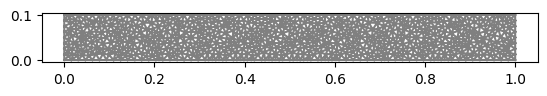

In [30]:
#https://github.com/cmaurini/damage-course/blob/a80c24003890ef152ef2595b40715ad40b39cba0/notebook/VarFrac.ipynb#L10
L = 1.; H = 0.1;
cell_size = 0.02;
nel = int(L/cell_size)
geom = Rectangle(Point(0., 0.), Point(L, H))
mesh = generate_mesh(geom,nel)
ndim = mesh.topology().dim() # get number of space dimensions
plot(mesh)

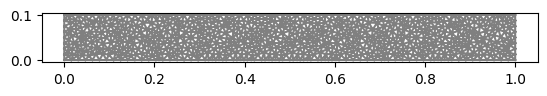

In [31]:
left = CompiledSubDomain("near(x[0], 0, 1e-4)")
right = CompiledSubDomain("near(x[0], %s, 1e-4)"%L)
boundaries = MeshFunction("size_t", mesh,1)
boundaries.set_all(0)
left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries, 2) # mark right as 2
ds = Measure("ds",subdomain_data=boundaries) # left: ds(1), right: ds(2)
plot(mesh)

In [32]:
E, nu = Constant(100.0), Constant(0.3)
Gc = Constant(1.0)
ell = Constant(0.05)

def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha

def a(alpha):
    """Stiffness modulation as a function of the damage """
    k_ell = Constant(1.e-6) # residual stiffness
    return (1-alpha)**2+k_ell

def eps(u):
    """Strain tensor as a function of the displacement"""
    return sym(grad(u))

def sigma_0(u):
    """Stress tensor of the undamaged material as a function of the displacement"""
    mu    = E/(2.0*(1.0 + nu))
    lmbda = E*nu/(1.0 - nu**2)
    return 2.0*mu*(eps(u)) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(u,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return (a(alpha))*sigma_0(u)

In [33]:
z = sympy.Symbol("z")
c_w = 4*sympy.integrate(sympy.sqrt(w(z)),(z,0,1))
print("c_w = ",c_w)
c_1w = sympy.integrate(sympy.sqrt(1/w(z)),(z,0,1))
print("c_1/w = ",c_1w)
tmp = 2*(sympy.diff(w(z),z)/sympy.diff(1/a(z),z)).subs({"z":0})
sigma_c = sympy.sqrt(tmp*Gc*E/(c_w*ell))
print("sigma_c = %2.3f"%sigma_c)
eps_c = float(sigma_c/E)
print("eps_c = %2.3f"%eps_c)

c_w =  8/3
c_1/w =  2
sigma_c = 27.386
eps_c = 0.274


In [34]:
# Create function space for 2D elasticity + Damage
V_u = VectorFunctionSpace(mesh, "P", 1)
V_alpha = FunctionSpace(mesh, "P", 1)

# Define the function, test and trial fields
u, du, v = Function(V_u), TrialFunction(V_u), TestFunction(V_u)
alpha, dalpha, beta = Function(V_alpha), TrialFunction(V_alpha), TestFunction(V_alpha)
u.rename('displacement','displacement')
u.rename('damage','damage')

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3e50d32d691510c6ddb9cf4f93c03cc00c26599a

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0119472 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0355251 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_041ef891a3dca1f43ee0d0575f5a8318c7941098

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00792861 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0301239 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

In [35]:
elastic_energy = 0.5*inner(sigma(u,alpha), eps(u))*dx
dissipated_energy = Gc/float(c_w)*(w(alpha)/ell + ell*dot(grad(alpha), grad(alpha)))*dx
total_energy = elastic_energy + dissipated_energy
# First directional derivative wrt u
E_u = derivative(total_energy,u,v)
# First and second directional derivative wrt alpha
E_alpha = derivative(total_energy,alpha,beta)
E_alpha_alpha = derivative(E_alpha,alpha,dalpha)

In [36]:
# Displacement
u_R = Expression(("t","0"),t = 0.,degree=0)
bcu_0 = DirichletBC(V_u, u_R, boundaries, 2)
bcu_1 = DirichletBC(V_u, Constant((0.,0.)), boundaries, 1)
bc_u = [bcu_0, bcu_1]
# Damage
bcalpha_0 = DirichletBC(V_alpha, 0.0, boundaries, 1)
bcalpha_1 = DirichletBC(V_alpha, 0.0, boundaries, 2)
bc_alpha = [bcalpha_0, bcalpha_1]

In [39]:
import ufl_legacy as ufl
E_du = ufl.replace(E_u,{u:du})
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d5fc09adc93f66840d5951aa4e3e3eddbca7073b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    4
  Coefficients:              '[f_4302, f_4303, f_4314, f_4317]'
  Unique elements:           'Vector<2 x CG1(?,?)>, R0(?,?), CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, R0(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degre

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_39ef27f4e90253c16d510fe0da7883ab043ff521

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00985885 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0690742 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_5da79ad1e5512f796233136b2befd13307ce5104

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00895715 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0235434 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

In [40]:
class DamageProblem(OptimisationProblem):

    def f(self, x):
        """Function to be minimised"""
        alpha.vector()[:] = x
        return assemble(total_energy)

    def F(self, b, x):
        """Gradient (first derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha, b)

    def J(self, A, x):
        """Hessian (second derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha_alpha, A)

solver_alpha_tao = PETScTAOSolver()
solver_alpha_tao.parameters.update({"method": "tron","linear_solver" : "umfpack",
                                    "line_search": "gpcg", "report": True})
lb = interpolate(Constant("0."), V_alpha) # lower bound, initialize to 0
ub = interpolate(Constant("1."), V_alpha) # upper bound, set to 1
for bc in bc_alpha:
    bc.apply(lb.vector())
    bc.apply(ub.vector())

In [41]:
def alternate_minimization(u,alpha,tol=1.e-5,maxiter=100,alpha_0=interpolate(Constant("0.0"), V_alpha)):
    # initialization
    iter = 1; err_alpha = 1
    alpha_error = Function(V_alpha)
    # iteration loop
    while err_alpha>tol and iter<maxiter:
        # solve elastic problem
        solver_u.solve()
        # solve damage problem
        #solver_alpha.solve()
        solver_alpha_tao.solve(DamageProblem(), alpha.vector(), lb.vector(), ub.vector())# test error
        alpha_error.vector()[:] = alpha.vector() - alpha_0.vector()
        err_alpha = norm(alpha_error.vector(),"linf")
        # monitor the results
        if MPI.comm_world.rank == 0:
            print("Iteration:  %2d, Error: %2.8g, alpha_max: %.8g" %(iter, err_alpha, alpha.vector().max()))
        # update iteration
        alpha_0.assign(alpha)
        iter=iter+1
    return (err_alpha, iter)

In [42]:
load0 = float(eps_c)*L # reference value for the loading (imposed displacement)
loads = load0*np.linspace(0,1.5,30)

In [43]:
savedir = "results/"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)
file_alpha = File(savedir+"/alpha.pvd")
file_u = File(savedir+"/u.pvd")
#  loading and initialization of vectors to store time datas
energies = np.zeros((len(loads),4))
iterations = np.zeros((len(loads),2))
forces = np.zeros((len(loads),2))
def postprocessing():
    plt.figure(i_t)
    plot(alpha,range_min=0.,range_max=1.,title="Damage at loading %.4f"%t)
    # Save number of iterations for the time step
    iterations[i_t] = np.array([t,i_t])
    # Calculate the energies
    elastic_energy_value = assemble(elastic_energy)
    surface_energy_value = assemble(dissipated_energy)
    if MPI.comm_world.rank == 0:
        print("\nEnd of timestep %d with load %g"%(i_t, t))
        print("\nElastic and surface energies: (%g,%g)"%(elastic_energy_value,surface_energy_value))
        print("-----------------------------------------")
    energies[i_t] = np.array([t,elastic_energy_value,surface_energy_value,elastic_energy_value+surface_energy_value])
    # Calculate the axial force resultant
    forces[i_t] = np.array([t,assemble(sigma(u,alpha)[0,0]*ds(1))])
    # Dump solution to file
    file_alpha << (alpha,t)
    file_u << (u,t)
    # Save some global quantities as a function of the time
    np.savetxt(savedir+'/energies.txt', energies)
    np.savetxt(savedir+'/forces.txt', forces)
    np.savetxt(savedir+'/iterations.txt', iterations)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7fe267655dd66c199647dc9844edc411d494bb1b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    7
  Coefficients:              '[f_4302, f_4303, f_4304, f_4305, damage, f_4314, f_431
                             7]'
  Unique elements:           'R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elemen

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_5de5462199a05c3748b3f7d6b346f78858dffcb4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00705457 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0228953 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_5c25266c1ba270afb02a03231b25e3fe1a270f5f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0103667 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0582151 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e7809bfbe496e865a51823bb7f3b74f1370b1b91

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00481582 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0134652 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_45d7d844971e204d20fd55d552c467e542b00e86

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0139153 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0393214 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_59fad816290f67022a1e68985e79484aaa4d24d9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    6
  Coefficients:              '[f_4302, f_4303, f_4304, f_4305, damage, f_4314]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vecto

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a8856da643d57932fde0209c93d26aa3a7ccfd89

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    5
  Coefficients:              '[f_4302, f_4303, f_4304, f_4305, damage]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2

Iteration:   1, Error:  0, alpha_max: 0
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_58baba0dcee52b63f472f21debc580a08efd89e2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    5
  Coefficients:              '[f_4302, f_4303, damage, f_4314, f_4317]'
  Unique elements:           'R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degre

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1bbe67b669debf95fb9fa81eea4f9ac0d9ffcc0e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    3
  Coefficients:              '[f_4304, f_4305, f_4314]'
  Unique elements:           'R0(?,?), CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'R0(?,?), CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0487154 seconds.

I


End of timestep 0 with load 0

Elastic and surface energies: (0,0)
-----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_743aff03f7092ad38f6ed79df519b738aea754ae

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 2
  Rank:                                0
  Arguments:                           '()'
  Number of coefficients:              5
  Coefficients:                        '[f_4302, f_4303, damage, f_4314, f_4518]'
  Unique elements:                     'R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:                 'R0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    u

Iteration:   1, Error:  0, alpha_max: 0

End of timestep 1 with load 0.0141653

Elastic and surface energies: (0.00100618,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 2 with load 0.0283305

Elastic and surface energies: (0.0040247,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 3 with load 0.0424958

Elastic and surface energies: (0.00905558,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 4 with load 0.056661

Elastic and surface energies: (0.0160988,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 5 with load 0.0708263

Elastic and surface energies: (0.0251544,0)
-----------------------------------------
Iteration:   1, Error:  0, alpha_max: 0

End of timestep 6 with load 0.0849915

Elastic and surface energies: (0.0362223,0)
-----------------------------------------
Ite

  plt.figure(i_t)



Iteration:  15, Error: 0.00023173105, alpha_max: 1
Iteration:  16, Error: 1.4009932e-06, alpha_max: 1

End of timestep 20 with load 0.283305

Elastic and surface energies: (0.000297809,0.109179)
-----------------------------------------
Iteration:   1, Error: 0.00093593567, alpha_max: 1
Iteration:   2, Error: 8.5381418e-06, alpha_max: 1

End of timestep 21 with load 0.29747

Elastic and surface energies: (0.000280789,0.109224)
-----------------------------------------
Iteration:   1, Error: 0.00082292249, alpha_max: 1
Iteration:   2, Error: 6.3427537e-06, alpha_max: 1

End of timestep 22 with load 0.311636

Elastic and surface energies: (0.000266671,0.109264)
-----------------------------------------
Iteration:   1, Error: 0.00072701377, alpha_max: 1
Iteration:   2, Error: 4.7639997e-06, alpha_max: 1

End of timestep 23 with load 0.325801

Elastic and surface energies: (0.000255036,0.109299)
-----------------------------------------
Iteration:   1, Error: 0.00064610379, alpha_max: 1
It

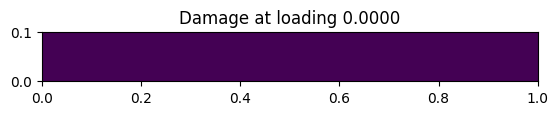

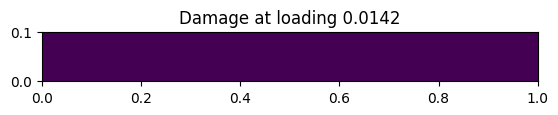

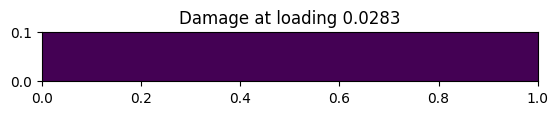

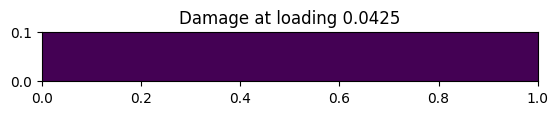

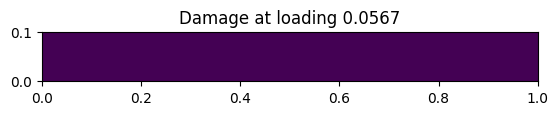

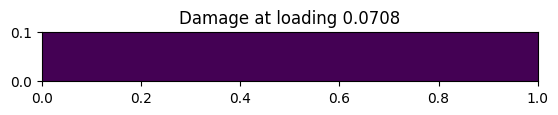

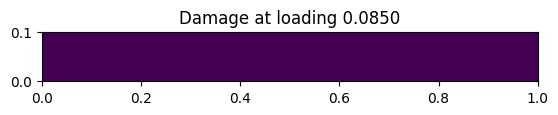

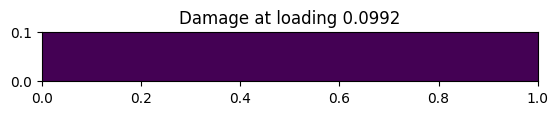

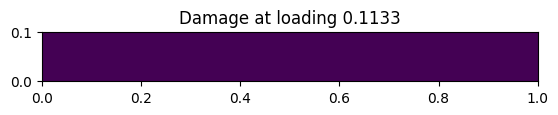

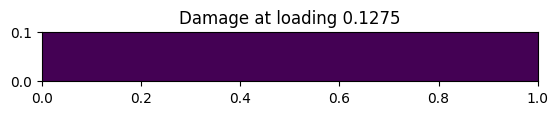

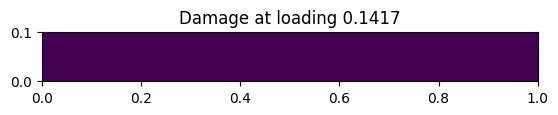

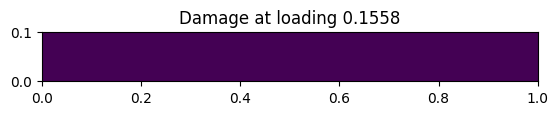

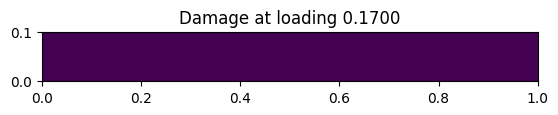

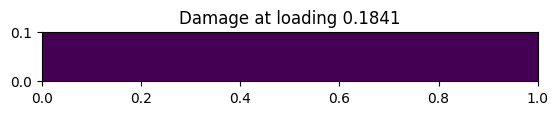

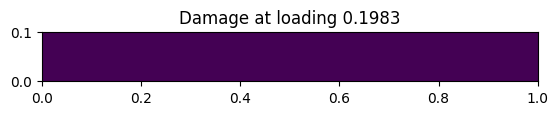

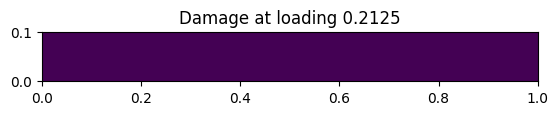

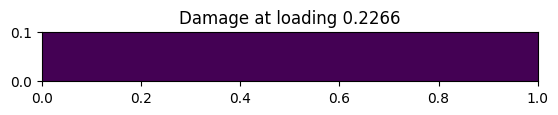

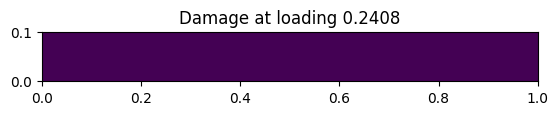

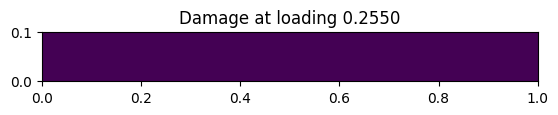

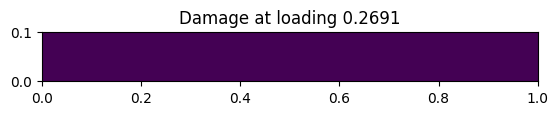

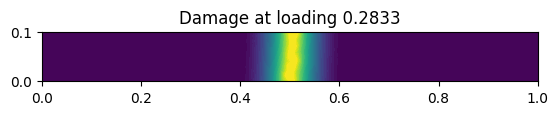

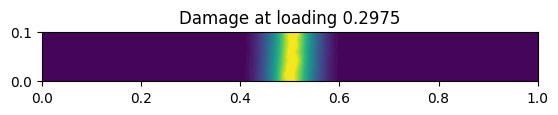

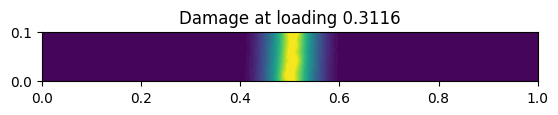

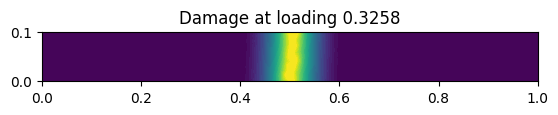

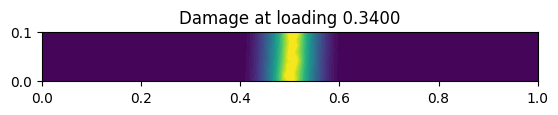

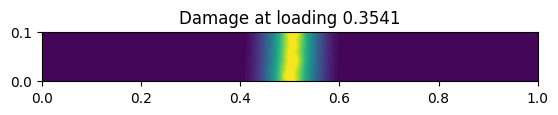

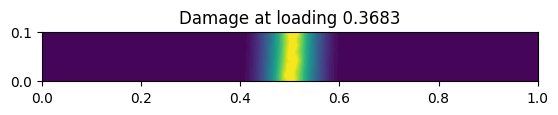

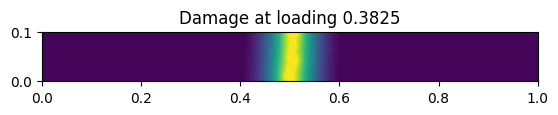

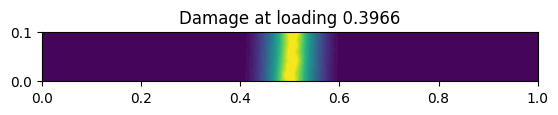

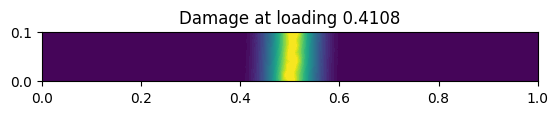

In [44]:
lb.interpolate(Constant(0.))
for (i_t, t) in enumerate(loads):
    u_R.t = t
    # solve alternate minimization
    alternate_minimization(u,alpha,maxiter=30)
    # updating the lower bound to account for the irreversibility
    lb.vector()[:] = alpha.vector()
    postprocessing()

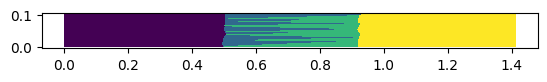

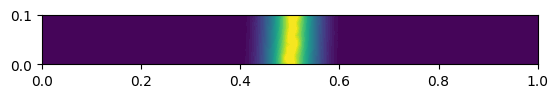

In [45]:
plt.figure(0)
plot(u,mode='displacement')
plt.figure(1)
plot(alpha)

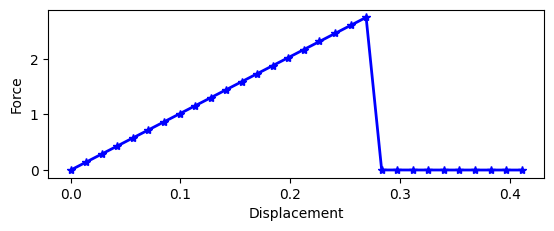

In [50]:
def critical_stress():
    xs = sympy.Symbol('x')
    wx = w(xs); sx = 1/(E*H*a(xs));
    res = sympy.sqrt(2*(Gc*H/c_w)*wx.diff(xs)/(sx.diff(xs)*ell))
    return res.evalf(subs={xs:0})

def plot_stress():
    plt.plot(forces[:,0], forces[:,1], 'b-*', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')
    # force_cr = critical_stress()
    # plt.axvline(x = force_cr/(E*H)*L, color = 'grey', linestyle = '--', linewidth = 2)
    # plt.axhline(y = force_cr, color = 'grey', linestyle = '--', linewidth = 2)

def plot_energy():
    p1, = plt.plot(energies[:,0], energies[:,1],'b*',linewidth=2)
    p2, = plt.plot(energies[:,0], energies[:,2],'r^',linewidth=2)
    p3, = plt.plot(energies[:,0], energies[:,3],'ko',linewidth=2)
    plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')
    # force_cr = critical_stress()
    # plt.axvline(x = force_cr/(E*H)*L, color = 'grey',linestyle = '--', linewidth = 2)
    # plt.axhline(y = H,color = 'grey', linestyle = '--', linewidth = 2)

def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    # plt.subplot(212)
    # plot_energy()
    # plt.savefig(savedir+'/energies_force.png')
    plt.show()

plot_energy_stress()

In [24]:
#https://newfrac.gitlab.io/newfrac-fenicsx-training/04-phase-field/phase-field.html
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

--2024-06-07 21:14:39--  https://fem-on-colab.github.io/releases/fenicsx-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4319 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.22K  --.-KB/s    in 0s      

2024-06-07 21:14:39 (32.7 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4319/4319]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/c990175/releases/pybind1

In [27]:
import matplotlib.pyplot as plt
import numpy as np

import dolfinx
import dolfinx.plot
import ufl

from mpi4py import MPI
from petsc4py import PETSc

import pyvista
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0.5)

import sys

#from snes_problem import SNESProblem

#from plots import plot_damage_state

In [28]:
L = 1.; H = 0.3;
ell_ = 0.1
cell_size = ell_/6;

nx = int(L/cell_size)
ny = int(H/cell_size)

mesh = dolfinx.RectangleMesh(MPI.COMM_WORLD, [(0.0, 0.0, 0.0), (L, H, 0.0)], [nx, ny])


ndim = mesh.geometry.dim


pyvista.OFF_SCREEN
topology, cell_types = dolfinx.plot.create_vtk_topology(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, mesh.geometry.x)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
plotter.add_axes()
plotter.set_scale(5,5)
#plotter.reset_camera(render=True, bounds=(-L/2, L/2, -H/2, H/2, 0, 0))
if not pyvista.OFF_SCREEN:
    plotter.show()

from pathlib import Path
Path("output").mkdir(parents=True, exist_ok=True)
figure = plotter.screenshot("output/mesh.png")

AttributeError: module 'dolfinx' has no attribute 'RectangleMesh'

In [21]:
import dolfin

In [22]:
import dolfinx

ModuleNotFoundError: No module named 'dolfinx'

In [23]:
pip install  dolfinx

ERROR: Could not find a version that satisfies the requirement dolfinx (from versions: none)
ERROR: No matching distribution found for dolfinx


https://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.anisotropy.html

In [15]:
pip install fipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.6/443.6 kB 6.4 MB/s eta 0:00:00


https://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.anisotropy.html

In [16]:
from fipy import Variable, CellVariable, Grid2D, TransientTerm, DiffusionTerm, ImplicitSourceTerm, Viewer, Matplotlib2DGridViewer
from fipy.tools import numerix
dx = dy = 0.025
if __name__ == '__main__':
    nx = ny = 500
else:
    nx = ny = 20
mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

In [17]:
dt = 5e-4

In [18]:
phase = CellVariable(name=r'$\phi$', mesh=mesh, hasOld=True)

In [19]:
dT = CellVariable(name=r'$\Delta T$', mesh=mesh, hasOld=True)

In [20]:
DT = 2.25
heatEq = (TransientTerm()
          == DiffusionTerm(DT)
          + (phase - phase.old) / dt)

In [21]:
alpha = 0.015
c = 0.02
N = 6.
theta = numerix.pi / 8.
psi = theta + numerix.arctan2(phase.faceGrad[1],
                              phase.faceGrad[0])
Phi = numerix.tan(N * psi / 2)
PhiSq = Phi**2
beta = (1. - PhiSq) / (1. + PhiSq)
DbetaDpsi = -N * 2 * Phi / (1 + PhiSq)
Ddia = (1.+ c * beta)
Doff = c * DbetaDpsi
I0 = Variable(value=((1, 0), (0, 1)))
I1 = Variable(value=((0, -1), (1, 0)))
D = alpha**2 * (1.+ c * beta) * (Ddia * I0 + Doff * I1)

In [22]:
tau = 3e-4
kappa1 = 0.9
kappa2 = 20.
phaseEq = (TransientTerm(tau)
           == DiffusionTerm(D)
           + ImplicitSourceTerm((phase - 0.5 - kappa1 / numerix.pi * numerix.arctan(kappa2 * dT))
                                * (1 - phase)))

In [23]:
radius = dx * 5.
C = (nx * dx / 2, ny * dy / 2)
x, y = mesh.cellCenters
phase.setValue(1., where=((x - C[0])**2 + (y - C[1])**2) < radius**2)

In [24]:
dT.setValue(-0.5)

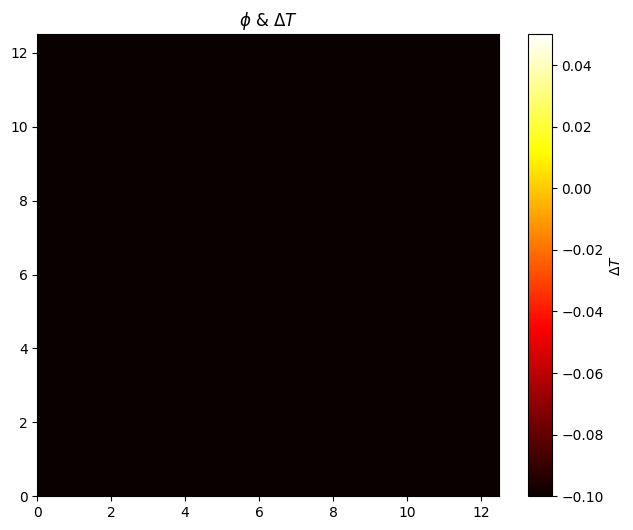

In [25]:
if __name__ == "__main__":
    try:
        import pylab
        class DendriteViewer(Matplotlib2DGridViewer):
            def __init__(self, phase, dT, title=None, limits={}, **kwlimits):
                self.phase = phase
                self.contour = None
                Matplotlib2DGridViewer.__init__(self, vars=(dT,), title=title,
                                                cmap=pylab.cm.hot,
                                                limits=limits, **kwlimits)

            def _plot(self):
                Matplotlib2DGridViewer._plot(self)

                if self.contour is not None:
                    for c in self.contour.collections:
                        c.remove()

                mesh = self.phase.mesh
                shape = mesh.shape
                x, y = mesh.cellCenters
                z = self.phase.value
                x, y, z = [a.reshape(shape, order='F') for a in (x, y, z)]

                self.contour = self.axes.contour(x, y, z, (0.5,))

        viewer = DendriteViewer(phase=phase, dT=dT,
                                title=r"%s & %s" % (phase.name, dT.name),
                                datamin=-0.1, datamax=0.05)
    except ImportError:
        viewer = MultiViewer(viewers=(Viewer(vars=phase),
                                      Viewer(vars=dT,
                                             datamin=-0.5,
                                             datamax=0.5)))

In [ ]:
if __name__ == '__main__':
    steps = 10000
else:
    steps = 10
from builtins import range
for i in range(steps):
    phase.updateOld()
    dT.updateOld()
    phaseEq.solve(phase, dt=dt)
    heatEq.solve(dT, dt=dt)
    if __name__ == "__main__" and (i % 10 == 0):
        viewer.plot()

In [ ]:
2+2

In [5]:
pip install pystencils[interactive]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00
  Created wheel for ipy-table: filename=ipy_table-1.15.1-py3-none-any.whl size=18744 sha256=1024f52171955328f72e391e64081d30feed245db786d9aa5d68112bf96c400f
  Stored in directory: /root/.cache/pip/wheels/e9/5c/49/5e9d7924df16a11e23bcdcca4eab6105c2aaec80f72c66c641
  Created wheel for pystencils: filename=pystencils-1.3.4-py3-none-any.whl size=266458 sha256=3763879b11849404b90

In [1]:
from pystencils.session import *
import pystencils as ps
sp.init_printing()
frac = sp.Rational

In [2]:
dh = ps.create_data_handling(domain_size=(300, 300), periodicity=True,
                             default_target=ps.Target.CPU)
φ_field = dh.add_array('phi', latex_name='φ')
φ_field_tmp = dh.add_array('phi_temp', latex_name='φ_temp')
φ_delta_field = dh.add_array('phidelta', latex_name='φ_D')
t_field = dh.add_array('T')

In [3]:
ε, m, δ, j, θzero, α, γ, Teq, κ, τ = sp.symbols("ε m δ j θ_0 α γ T_eq κ τ")
εb = sp.Symbol("\\bar{\\epsilon}")

φ = φ_field.center
φ_tmp = φ_field_tmp.center
T = t_field.center

def f(φ, m):
    return φ**4 / 4 - (frac(1, 2) - m/3) * φ**3 + (frac(1,4)-m/2)*φ**2

free_energy_density = ε**2 / 2 * (ps.fd.Diff(φ,0)**2 + ps.fd.Diff(φ,1)**2 ) + f(φ, m)
free_energy_density

   4                                  2 ⎛         2            2⎞
φ_C       3 ⎛1   m⎞      2 ⎛1   m⎞   ε ⋅⎝D(φ[0,0])  + D(φ[0,0]) ⎠
──── - φ_C ⋅⎜─ - ─⎟ + φ_C ⋅⎜─ - ─⎟ + ────────────────────────────
 4          ⎝2   3⎠        ⎝4   2⎠                2              

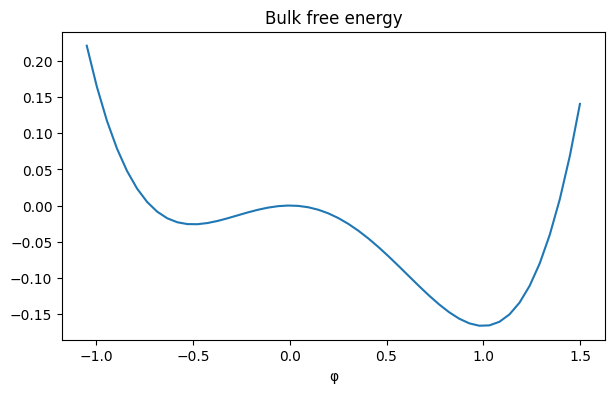

In [4]:
plt.figure(figsize=(7,4))
plt.sympy_function(f(φ, m=1), x_values=(-1.05, 1.5) )
plt.xlabel("φ")
plt.title("Bulk free energy");

In [5]:
def σ(θ):
    return 1 + δ * sp.cos(j * (θ - θzero))

θ = sp.atan2(ps.fd.Diff(φ, 1), ps.fd.Diff(φ, 0))

ε_val = εb * σ(θ)
ε_val

\bar{\epsilon}⋅(δ⋅cos(j⋅(-θ₀ + atan2(D(φ[0,0]), D(φ[0,0])))) + 1)

In [6]:
def m_func(T):
    return (α / sp.pi) * sp.atan(γ * (Teq - T))

In [7]:
fe = free_energy_density.subs({
    m: m_func(T),
    ε: εb * σ(θ),
})

dF_dφ = ps.fd.functional_derivative(fe, φ)
dF_dφ = ps.fd.expand_diff_full(dF_dφ, functions=[φ])
dF_dφ

          2                               2                                   
   3   φ_C ⋅α⋅atan(T_C⋅γ - T_eq⋅γ)   3⋅φ_C    φ_C⋅α⋅atan(T_C⋅γ - T_eq⋅γ)   φ_C
φ_C  - ─────────────────────────── - ────── + ────────────────────────── + ───
                    π                  2                  π                 2 

                                                                              
                 2  2    2                                                    
 - \bar{\epsilon} ⋅δ ⋅cos (j⋅θ₀ - j⋅atan2(D(φ[0,0]), D(φ[0,0])))⋅D(D(φ[0,0])) 
                                                                              

                                                                              
                2  2    2                                                     
- \bar{\epsilon} ⋅δ ⋅cos (j⋅θ₀ - j⋅atan2(D(φ[0,0]), D(φ[0,0])))⋅D(D(φ[0,0])) -
                                                                              

                                                 

In [8]:
discretize = ps.fd.Discretization2ndOrder(dx=0.03, dt=1e-5)
parameters = {
    τ: 0.0003,
    κ: 1.8,
    εb: 0.01,
    δ: 0.02,
    γ: 10,
    j: 6,
    α: 0.9,
    Teq: 1.0,
    θzero: 0.2,
    sp.pi: sp.pi.evalf()
}
parameters

{π: 3.14159265358979, T_eq: 1.0, \bar{\epsilon}: 0.01, j: 6, α: 0.9, γ: 10, δ:
 0.02, θ₀: 0.2, κ: 1.8, τ: 0.0003}

In [9]:
dφ_dt = - dF_dφ / τ
φ_eqs = ps.simp.sympy_cse_on_assignment_list([ps.Assignment(φ_delta_field.center,
                                                            discretize(dφ_dt.subs(parameters)))])
φ_eqs.append(ps.Assignment(φ_tmp, discretize(ps.fd.transient(φ) - φ_delta_field.center)))

temperature_evolution = -ps.fd.transient(T) + ps.fd.diffusion(T, 1) + κ * φ_delta_field.center
temperature_eqs = [
    ps.Assignment(T, discretize(temperature_evolution.subs(parameters)))
]

In [10]:
φ_kernel = ps.create_kernel(φ_eqs, cpu_openmp=4, target=dh.default_target).compile()
temperature_kernel = ps.create_kernel(temperature_eqs, target=dh.default_target).compile()

In [11]:
def timeloop(steps=200):
    φ_sync = dh.synchronization_function(['phi'])
    temperature_sync = dh.synchronization_function(['T'])
    dh.all_to_gpu()  # this does nothing when running on CPU
    for t in range(steps):
        φ_sync()
        dh.run_kernel(φ_kernel)
        dh.swap('phi', 'phi_temp')
        temperature_sync()
        dh.run_kernel(temperature_kernel)
    dh.all_to_cpu()
    return dh.gather_array('phi')

def init(nucleus_size=np.sqrt(5)):
    for b in dh.iterate():
        x, y = b.cell_index_arrays
        x, y = x-b.shape[0]//2, y-b.shape[0]//2
        bArr = (x**2 + y**2) < nucleus_size**2
        b['phi'].fill(0)
        b['phi'][(x**2 + y**2) < nucleus_size**2] = 1.0
        b['T'].fill(0.0)

def plot():
    plt.subplot(1,3,1)
    plt.scalar_field(dh.gather_array('phi'))
    plt.title("φ")
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title("T")
    plt.scalar_field(dh.gather_array('T'))
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("∂φ")
    plt.scalar_field(dh.gather_array('phidelta'))
    plt.colorbar()

In [12]:
ps.show_code(φ_kernel)

   1 FUNC_PREFIX void kernel(double * RESTRICT const _data_T, double * RESTRICT const _data_phi, double * RESTRICT 
   2 {                                                                                                             
   3    #pragma omp parallel num_threads(4)                                                                        
   4    {                                                                                                          
   5       #pragma omp for schedule(static)                                                                        
   6       for (int64_t ctr_1 = 1; ctr_1 < 301; ctr_1 += 1)                                                        
   7       {                                                                                                       
   8          for (int64_t ctr_0 = 1; ctr_0 < 301; ctr_0 += 1)                                                     
   9          {                                                                                                    
  10             const double xi_0 = _data_phi[ctr_0 + 302*ctr_1]*_data_phi[ctr_0 + 302*ctr_1];                    
  11             const double xi_1 = 954.92965855137209*atan(-10.0 + 10.0*_data_T[ctr_0 + 302*ctr_1]);             
  12             const double xi_2 = -2222.2222222222222*_data_phi[ctr_0 + 302*ctr_1];                             
  13             const double xi_3 = xi_2 + 1111.1111111111111*_data_phi[ctr_0 + 302*ctr_1 + 302] + 1111.1111111111
  14             const double xi_4 = cos(-1.2000000000000002 + 6.0*atan2(-16.666666666666668*_data_phi[ctr_0 + 302*
  15             const double xi_5 = xi_4*0.013333333333333336;                                                    
  16             const double xi_6 = xi_2 + 1111.1111111111111*_data_phi[ctr_0 + 302*ctr_1 + 1] + 1111.111111111111
  17             const double xi_7 = 0.00013333333333333334*(xi_4*xi_4);                                           
  18             _data_phidelta[ctr_0 + 302*ctr_1] = xi_0*xi_1 + xi_0*5000.0 -[38

    Name|      Inner (min/max)|     WithGl (min/max)
----------------------------------------------------
       T|            (  0,  0)|            (  0,  0)
     phi|            (  0,  1)|            (  0,  1)
phi_temp|            (nan,nan)|            (nan,nan)
phidelta|            (nan,nan)|            (nan,nan)



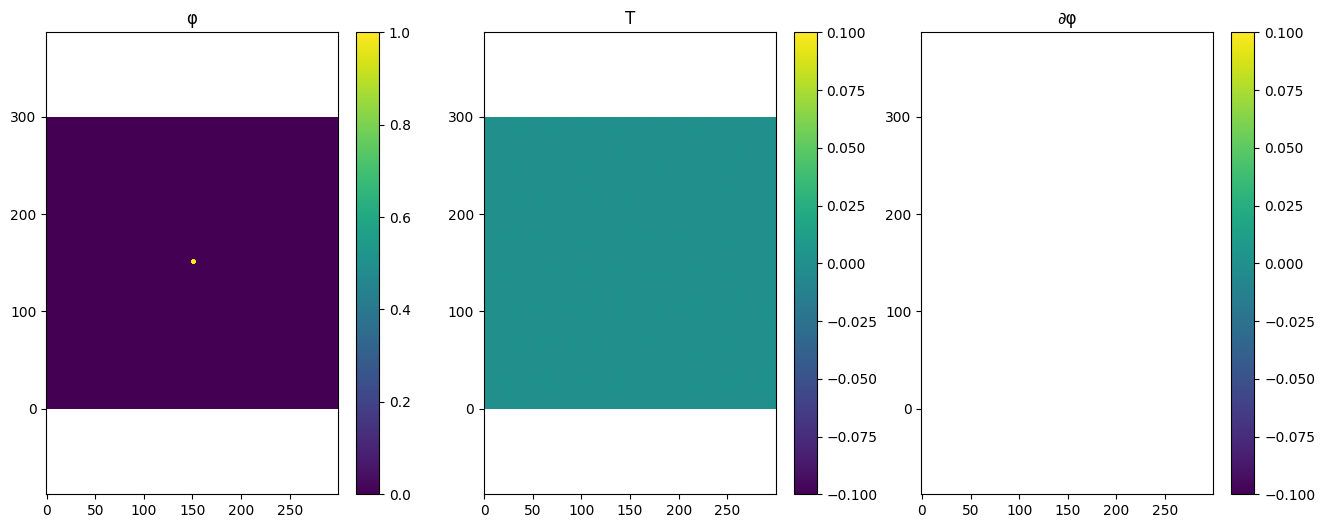

In [13]:
timeloop(10)
init()
plot()
print(dh)

In [14]:
result = None
if 'is_test_run' not in globals():
    ani = ps.plot.scalar_field_animation(timeloop, rescale=True, frames=600)
    result = ps.jupyter.display_as_html_video(ani)
result

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1600x600', '-pix_fmt', 'rgba', '-r', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-profile:v', 'baseline', '-level', '3.0', '-y', '/tmp/tmp7thlpnoo.mp4']' returned non-zero exit status 255.

In [1]:
%%time
try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl_legacy
    import dolfin
else:
    try:
        import ufl_legacy
        import dolfin
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import ufl_legacy
        import dolfin

--2024-06-07 20:43:55--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-06-07 20:43:55 (38.6 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/c990175/releases/pybind11-inst

In [19]:
from fenics import *
import matplotlib.pyplot as plt

# Simulation parameters
L = 5.0         # Length of the car (in meters)
H = 2.0         # Height of the car (in meters)
nx, ny = 50, 20 # Mesh resolution
E = 210e9       # Young's modulus (Pa)
nu = 0.3        # Poisson's ratio
rho = 7800      # Density (kg/m^3)
t_end = 0.01    # End time (seconds)
dt = 1e-4       # Time step (seconds)

# Create mesh and define function space
mesh = RectangleMesh(Point(0, 0), Point(L, H), nx, ny)
V = VectorFunctionSpace(mesh, 'P', 1)

# Define functions
u = Function(V)       # Displacement field
u_n = Function(V)     # Displacement field from previous time step
v = Function(V)       # Velocity field
v_n = Function(V)     # Velocity field from previous time step
a = Function(V)       # Acceleration field

# Define test function
du = TestFunction(V)

# Kinematics
d = u - u_n
d = variable(d)
I = Identity(len(d))
F = I + grad(d)
C = F.T * F
E = 0.5 * (C - I)
psi = (E**2).trace() * (E**2).trace() # Simplified strain energy density
P = diff(psi, F) # First Piola-Kirchhoff stress tensor

# Weak form of the momentum equation
F = rho * inner(a, du) * dx - inner(P, grad(du)) * dx

# Boundary conditions
def boundary(x, on_boundary):
    return on_boundary and near(x[0], 0)

bc = DirichletBC(V, Constant((0, 0)), boundary)

# Initial conditions
u.assign(Constant((0, 0)))
v.assign(Constant((10, 0))) # Initial velocity of 10 m/s towards the wall

# Time-stepping
t = 0
while t < t_end:
    t += dt

    # Update acceleration
    solve(lhs(F) == rhs(F), a, bc)

    # Update velocity and displacement
    v.vector()[:] = v_n.vector() + dt * a.vector()
    u.vector()[:] = u_n.vector() + dt * v.vector()

    # Update previous time step fields
    u_n.assign(u)
    v_n.assign(v)

    # Plot the displacement field
    plt.figure()
    plot(u, title=f'Displacement at time {t:.4f}')
    plt.show()

# Final plot
plt.figure()
plot(u, title='Final Displacement')
plt.show()


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e5d9aa4d89f38731119142501218e55629da4e4f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00607228 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0231903 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

AttributeError: 'Inner' object has no attribute 'trace'

In [5]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Parameters
# Define the problem parameters
L = 10.0        # Length of the domain
nx = 100        # Number of mesh points
dt = 0.01       # Time step size
num_steps = 200 # Number of time steps
epsilon = 0.1   # Interface thickness parameter
M = 1.0         # Mobility
W = 1.0         # Potential well height

# Create mesh and define function space
mesh = IntervalMesh(nx, 0, L)
V = FunctionSpace(mesh, 'P', 1)

# Define the initial condition
class InitialCondition(UserExpression):
    def eval(self, values, x):
        values[0] = 0.5 * (1 + np.tanh((x[0] - 5) / (2 * np.sqrt(2) * epsilon)))
    def value_shape(self):
        return ()

phi = Function(V)
phi_n = Function(V)
phi_init = InitialCondition(degree=2)
phi.interpolate(phi_init)
phi_n.assign(phi)

# Define the test function
v = TestFunction(V)

# Define the weak form of the Allen-Cahn equation
F = (phi - phi_n) / dt * v * dx + M * dot(grad(phi), grad(v)) * dx + W * (phi**3 - phi) * v * dx
a, L = lhs(F), rhs(F)

# Time-stepping
t = 0
for n in range(num_steps):
    t += dt
    solve(a == L, phi)
    phi_n.assign(phi)

    # Plot the solution at selected time steps
    if n % 50 == 0:
        plt.figure()
        plot(phi, title=f'Time step {n}')
        plt.xlabel('x')
        plt.ylabel('phi')
        plt.grid(True)
        plt.show()

# Final plot
plt.figure()
plot(phi, title='Final Phase Field')
plt.xlabel('x')
plt.ylabel('phi')
plt.grid(True)
plt.show()


Form has no parts with arity 2.


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_650fe70c9e392b0c2d992d85d5d80ed1b6e69641

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_37, f_40]'
  Unique elements:           'CG1(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<1 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.153658 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f15c62f5d90fd349915de9977c93d95ae6a6e4ca

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0042994 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0248744 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_7b2d1da84570d09b9efefe42fa819358fb99594c

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00406027 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0228767 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_22ac9d415453b285f29b535bd2d228fc6513b855

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:    1
  Rank:                   0
  Arguments:              '()'
  Number of coefficients: 0
  Coefficients:           '[]'
  Unique elements:        'Vector<1 x CG1(?,?)>'
  Unique sub elements:    'Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  Quadrature rule must be equal within each sub domain, using canonical rule.
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0211692 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing re

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     https://fenicsproject.discourse.group/
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to define linear variational problem a(u, v) == L(v) for all v.
*** Reason:  Expecting the left-hand side to be a bilinear form (not rank 0).
*** Where:   This error was encountered inside LinearVariationalProblem.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  1c52e837eb54cc34627f90bde254be4aa8a2ae17
*** -------------------------------------------------------------------------


In [4]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Parameters
L = 1.0           # Length of the domain
H = 1.0           # Height of the domain
nx, ny = 50, 50   # Mesh resolution
dt = 0.01         # Time step size
num_steps = 1000  # Number of time steps
epsilon = 0.01    # Interface thickness
W = 1.0           # Potential height
M = 1.0           # Mobility
kappa = 1.0       # Thermal conductivity
latent_heat = 1.0 # Latent heat of fusion

# Create mesh and define function spaces
mesh = RectangleMesh(Point(0, 0), Point(L, H), nx, ny)
V = FunctionSpace(mesh, 'P', 1)    # Function space for phase field and temperature

# Define functions
phi = Function(V)       # Phase field
phi_n = Function(V)     # Phase field from previous time step
T = Function(V)         # Temperature field
T_n = Function(V)       # Temperature field from previous time step

# Initial condition for phase field (ice in the center)
phi_init = Expression('1.0 - exp(-100*(pow(x[0]-0.5,2)+pow(x[1]-0.5,2)))', degree=2)
phi.interpolate(phi_init)
phi_n.assign(phi)

# Initial condition for temperature (cold in the center, warmer outside)
T_init = Expression('0.5 * (1 - tanh(10*(sqrt(pow(x[0]-0.5,2) + pow(x[1]-0.5,2)) - 0.25)))', degree=2)
T.interpolate(T_init)
T_n.assign(T)

# Define test functions
v = TestFunction(V)
w = TestFunction(V)

# Free energy density (double-well potential)
f_phi = W * phi**2 * (1 - phi)**2

# Chemical potential
mu = f_phi - epsilon**2 * div(grad(phi))

# Weak form for phase field
F_phi = (phi - phi_n) / dt * v * dx + M * dot(grad(mu), grad(v)) * dx - latent_heat * (T - 0.5) * v * dx
a_phi, L_phi = lhs(F_phi), rhs(F_phi)

# Weak form for temperature
F_T = (T - T_n) / dt * w * dx + kappa * dot(grad(T), grad(w)) * dx - latent_heat * (phi - phi_n) / dt * w * dx
a_T, L_T = lhs(F_T), rhs(F_T)

# Time-stepping
for n in range(num_steps):
    # Solve phase field equation
    solve(a_phi == L_phi, phi)
    phi_n.assign(phi)

    # Solve temperature equation
    solve(a_T == L_T, T)
    T_n.assign(T)

    # Plot results every 100 steps
    if n % 100 == 0:
        plt.figure()
        plot(phi, title=f'Phase Field at step {n}')
        plt.show()
        plt.figure()
        plot(T, title=f'Temperature Field at step {n}')
        plt.show()

# Final plots
plt.figure()
plot(phi, title='Final Phase Field')
plt.show()
plt.figure()
plot(T, title='Final Temperature Field')
plt.show()


Form has no parts with arity 2.


Form has no parts with arity 2.


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_47b06ae184f0c21f98d95afaae92a86e9bdc4281

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_49, f_52, f_55]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_degree: 3
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0580924 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c31d4a7981caba1aedfadd8d27f2e6398b9aee9d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:    2
  Rank:                   0
  Arguments:              '()'
  Number of coefficients: 0
  Coefficients:           '[]'
  Unique elements:        'Vector<2 x CG1(?,?)>'
  Unique sub elements:    'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  Quadrature rule must be equal within each sub domain, using canonical rule.
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0129044 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing re

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     https://fenicsproject.discourse.group/
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to define linear variational problem a(u, v) == L(v) for all v.
*** Reason:  Expecting the left-hand side to be a bilinear form (not rank 0).
*** Where:   This error was encountered inside LinearVariationalProblem.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  1c52e837eb54cc34627f90bde254be4aa8a2ae17
*** -------------------------------------------------------------------------


In [6]:
from dolfin import *

mesh = UnitSquareMesh(100, 100)

V = FunctionSpace(mesh, 'CG',1)
u = Function(V)
v = TestFunction(V)
f = Constant(0.0)
delta=Constant(0.04)

F = delta* inner(grad(u), grad(v))*dx +1/delta*inner(u**3-u,v)*dx

bclr=DirichletBC(V,+1, "x[0]==0.0 || x[0]==1.0")
bctb=DirichletBC(V,-1, "x[1]==0.0 || x[1]==1.0")


pvd=File("Allen-Cahn.pvd")

for ig in [0,1,-1]:
	u.interpolate(Constant(ig))
	solve(F==0, u, [bclr,bctb])
	pvd<<u


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5146ff23f3faadefceb01df50ceb8b2d1f01401d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_50, f_54]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0434897 seconds.

INFO:FFC:Compiler st

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00752711 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0281641 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0122828 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0254266 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_80ab5b902df2971fc83c9f776876d89835065e66

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_50, f_54]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0392964 seconds.

INFO:FFC:Compil

In [7]:
!ls -altr

total 2564
drwxr-xr-x 4 root root   4096 Jun  6 14:15 .config
drwxr-xr-x 1 root root   4096 Jun  6 14:21 sample_data
drwxr-xr-x 1 root root   4096 Jun  7 20:43 ..
-rw-r--r-- 1 root root 865696 Jun  7 20:51 Allen-Cahn000000.vtu
-rw-r--r-- 1 root root 862242 Jun  7 20:51 Allen-Cahn000001.vtu
drwxr-xr-x 1 root root   4096 Jun  7 20:51 .
-rw-r--r-- 1 root root    304 Jun  7 20:51 Allen-Cahn.pvd
-rw-r--r-- 1 root root 869167 Jun  7 20:51 Allen-Cahn000002.vtu


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_f2336f79fa3bc3abaec5c7618a3d7b9c67b60b9d

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00838637 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.034704 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_46c924d9bd9fcb19e8a16fa205d8fc69c85a115d

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_10435, f_10438]'
  Unique elements:           'CG2(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0685663 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
IN

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0fdb0494d9e8b4bb5c988ddcdf2fb76eba70934f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00332379 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0139923 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_1f1780c898fee060c86feffbb0f17736150c2056

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00899196 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0487862 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_6e560500c3a4b2c505d894dc7603a792bcf1306f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00927997 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0446029 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_b1501760c5f74e198ffdcd27f0238c9b23a384cf

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0148008 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0260191 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_04679d5f1522e7c9146c367d5e91f180109aef2f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       1
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_10435]'
  Unique elements:           'CG2(?,?), Vector<1 x CG1(?,?)>'
  Unique sub elements:       'CG2(?,?), Vector<1 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0758989 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:F

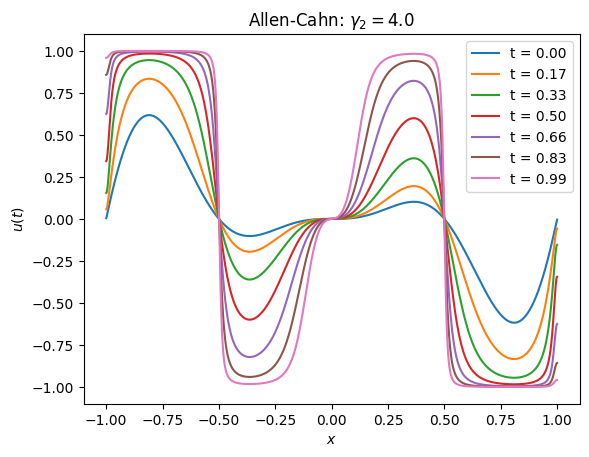

In [51]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#https://fenicsproject.discourse.group/t/periodic-boundary-conditions-for-allen-cahn/4452
# parameters
#####################################
nx       = 1000        # mesh points
theta    = 0.5         # time discretization
dt       = 5.0e-3      # time step
(x0, xf) = (-1.0, 1.0) # boundaries
order    = 2           # mesh polynomial order

# Class for interfacing with the Newton solver
class AllenCahnEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return bool(x[0] < DOLFIN_EPS and x[0] > -DOLFIN_EPS and on_boundary)

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)

# formulate problem
#####################################
# create periodic boundary condition
pbc = PeriodicBoundary()

# setup mesh
mesh = IntervalMesh(nx, x0, xf)
V = FunctionSpace(mesh, "CG", order, constrained_domain=pbc)

# define test & trial functions
du = TrialFunction(V)
v = TestFunction(V)

# define functions
u = Function(V)
u0 = Function(V)

# initial conditions
u_init = Expression("pow(x[0],2)*sin(2*pi*x[0])", degree=2)
u.interpolate(u_init)
u0.interpolate(u_init)

mu_mid = (1.0-theta)*u0 + theta*u
gamma1 = 0.0001
gamma2 = 4.0 # {1 (easiest):4 (hardest)}

F = u*v*dx - u0*v*dx +                    \
    dt*gamma1*dot(grad(u), grad(v))*dx +  \
    dt*gamma2*(u**3 - u)*v*dx

J = derivative(F, u, du)

problem = AllenCahnEquation(J, F)
solver = NewtonSolver()

# map mesh vertices to solution DOFs
#####################################
dof_coordinates = V.tabulate_dof_coordinates()

# get indicies of sorted result
dofs      = np.squeeze(dof_coordinates)
asc_order = np.argsort(dofs)

# time stepping
#####################################
(t, T) = (0.0, 1.0)

plt.figure
plt.title(f"Allen-Cahn: $\gamma_2={gamma2}$")
plt.ylabel("$u(t)$")
plt.xlabel("$x$")
labels = []

while t < T:

    # compute current solution
    solver.solve(problem, u.vector())

    # update previous solution
    u0.vector()[:] = u.vector()

    # plot 6 solution snapshots
    if round(t/dt) % round(T/dt/6) == 0:
        plt.plot(dofs[asc_order], u.vector()[asc_order])
        labels.append(f"t = {t/T:.2f}")

    # increment time
    t += dt
    n += 1

plt.legend(labels)
plt.show()

In [15]:
import random
from dolfin import *
# Class representing the intial conditions
class InitialConditions(Expression):
    def __init__(self):
        random.seed(2 + MPI.rank(mpi_comm_world()))
    def eval(self, values, x):
        values[0] = 0.63 + 0.02*(0.5 - random.random())
        values[1] = 0.0
    def value_shape(self):
        return (2,)
# Class for interfacing with the Newton solver
class CahnHilliardEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)


In [17]:
# Model parameters
lmbda  = 1.0e-02  # surface parameter
dt     = 5.0e-06  # time step
theta  = 0.5      # time stepping family, e.g. theta=1 -> backward Euler, theta=0.5 -> Crank-Nicolson
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
# Create mesh and define function spaces
mesh = UnitSquareMesh(96, 96)
V = FunctionSpace(mesh, "Lagrange", 1)
ME = inner(V,V)

UFLValueError: Invalid type conversion: FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 4263), FiniteElement('Lagrange', triangle, 1)) can not be converted to any UFL type.

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7ac02186a034097be1a799e56117b4e7492f4ce6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_7]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.106275 seconds.

INFO:FFC:Compiler stage 2: C

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00340414 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0163164 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00524879 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0167284 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00899434 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0133872 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6d178efb7219a9d3a72860e27d0bb2cc12542b0f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.140297 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_76fc3cd9625812038c7471125b47cc4c7ae9ad4e

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00378966 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 1.16924 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6ce8a510087f4e034b86fc6d0bf27a775643b273

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    1
  Coefficients:              '[f_30]'
  Unique elements:           'DG4(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG4(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0232935 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00435328 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0175765 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0142789 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0409558 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_8f9acf292fa7994d298cc8c76ab5884f206fd987

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00621057 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0251327 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00966501 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0181224 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


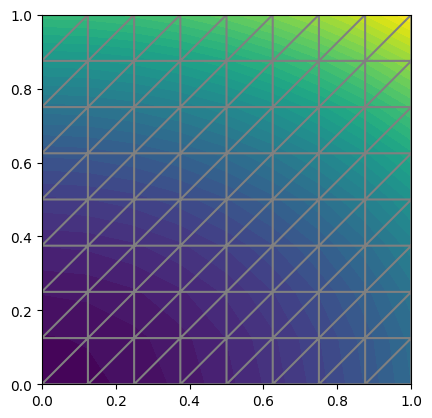

In [1]:
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary

  u_D = 1 + x^2 + 2y^2
    f = -6
"""

from __future__ import print_function
from fenics import *
import matplotlib.pyplot as plt

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u)
plot(mesh)

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
plt.show()

This code sets up and solves the Allen-Cahn equation for a phase field simulation using the FEniCS library. The simulation runs for a specified number of time steps, updating and plotting the phase field periodically. The initial condition is a sine function with small perturbations, and the solution is computed using the finite element method.

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a55c8cf853c08b5d075fd9dd73de3fe59a1252a2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_44]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.115158 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_97306e57896c09a96f55c99da7a21bec7c784777

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0513415 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

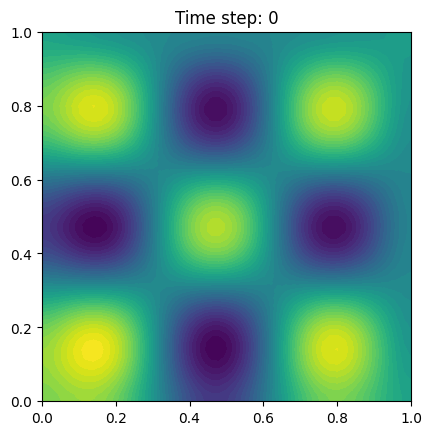

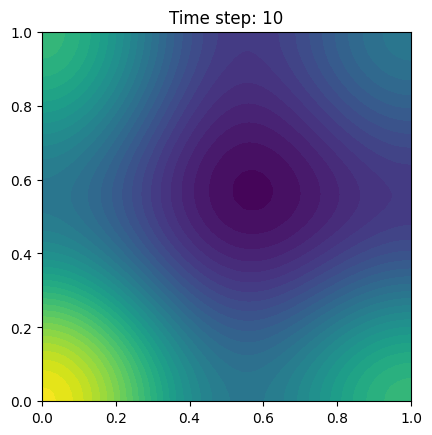

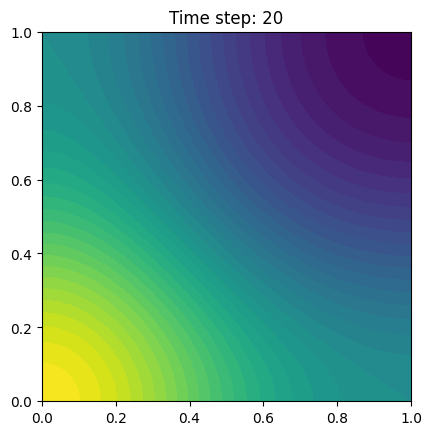

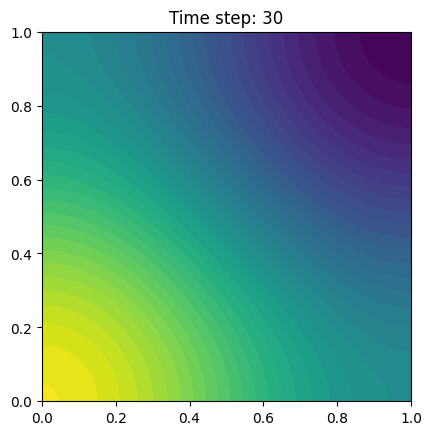

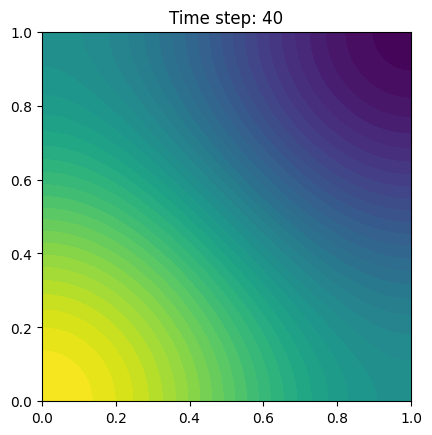

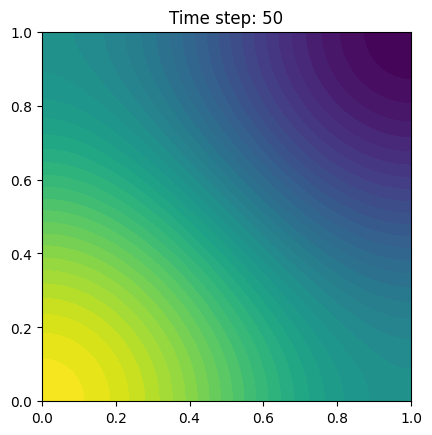

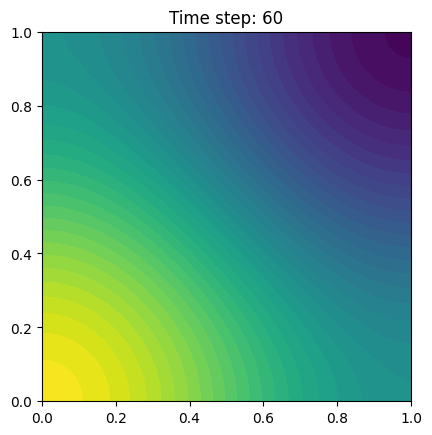

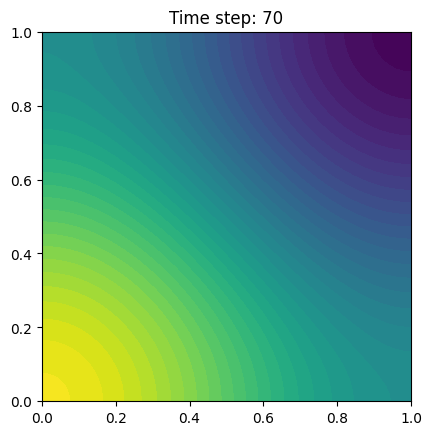

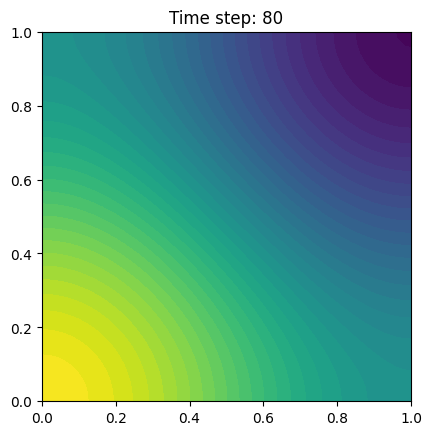

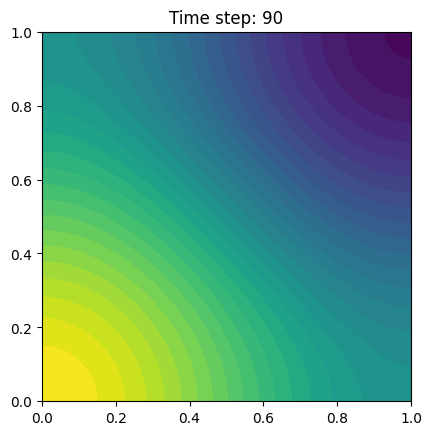

In [2]:
from fenics import *
import matplotlib.pyplot as plt

# Parameters
L = 1.0
dt = 0.01
num_steps = 100

# Create mesh and define function space
nx, ny = 50, 50
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Initial condition
phi = Function(V)
phi.interpolate(Expression('0.5 + 0.01*sin(10*x[0])*sin(10*x[1])', degree=2))

# Define weak form
phi_n = Function(V)
phi_n.assign(phi)
phi_trial = TrialFunction(V)
v = TestFunction(V)
f = phi_n * (1 - phi_n) * (0.5 - phi_n)
F = (phi_trial - phi_n) / dt * v * dx + L * f * v * dx + dot(grad(phi_trial), grad(v)) * dx

a, L = lhs(F), rhs(F)

# Time-stepping
for n in range(num_steps):
    solve(a == L, phi)
    phi_n.assign(phi)

    if n % 10 == 0:
        plt.figure()
        plot(phi)
        plt.title(f'Time step: {n}')
        plt.show()


Problem Description
The objective is to model crack propagation in a material using a phase field approach, which involves solving a system of coupled partial differential equations (PDEs) for the displacement field and the phase field. The phase field represents the state of the material, indicating intact or cracked regions. The displacement field describes the deformation of the material under applied loads.

Key Components and Methods
Governing Equations:

The displacement field
𝑢
u is governed by the equilibrium equation derived from the principle of virtual work.
The phase field
𝜙
ϕ evolves according to an energy minimization principle, incorporating the fracture energy and a length scale parameter.
Elasticity Parameters:

Young's Modulus

E and Poisson's Ratio
𝜈
 define the material's elastic properties.
The Lame parameters
𝜇
μ and
𝜆
λ are derived from
𝐸
E and
𝜈
ν.
Energy Functional:

The total energy functional includes the elastic energy, the fracture energy, and a degradation function that couples the displacement and phase fields.
Boundary and Initial Conditions:

Displacement boundary conditions are applied to simulate loading.
The phase field is initially set to represent an undamaged material.
Numerical Solution:

The finite element method (FEM) is used to discretize and solve the coupled PDEs.
The FEniCS library provides the computational framework for implementing the FEM.
Time-Stepping and Load Application:

The load is incrementally applied, and the system is solved iteratively for each time step.
Reaction forces are computed to generate the load-displacement curve, which provides insight into the material's response to loading and the progression of cracking.
Implementation Highlights
Mesh and Function Spaces:

A rectangular mesh is created, and function spaces for the displacement and phase fields are defined.
Weak Forms:

The weak forms of the displacement and phase field equations are derived and implemented.
These forms are integrated over the domain and solved iteratively.
Boundary Conditions:

Dirichlet boundary conditions fix displacements on one side and apply incremental loading on the opposite side.
Visualization:

The load-displacement curve is plotted to analyze the mechanical response.
The final phase field and displacement field are visualized to understand the crack propagation pattern.
Results and Analysis
The simulation provides a detailed analysis of how cracks initiate and propagate in the material under applied loading. The load-displacement curve offers insight into the material's mechanical properties, such as stiffness and fracture toughness. The final phase field visualization highlights the regions where cracks have formed and propagated, allowing for a better understanding of the fracture process.

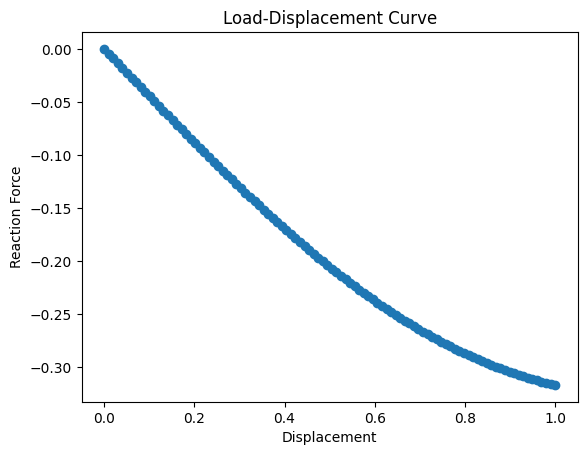

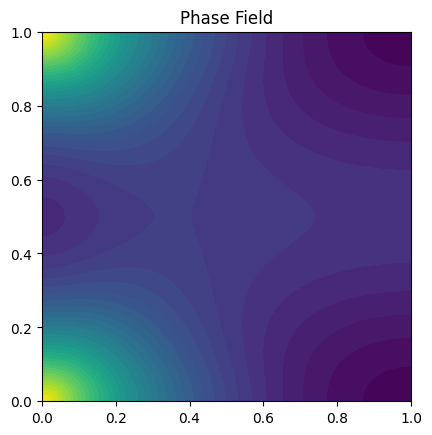

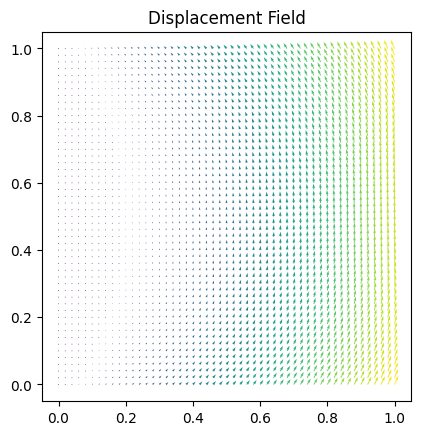

In [5]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

# Parameters
L = 1.0         # Length of the domain
H = 1.0         # Height of the domain
nx, ny = 50, 50 # Mesh resolution
E = 10.0        # Young's modulus
nu = 0.3        # Poisson's ratio
Gc = 1.0        # Fracture energy
ell = 0.1       # Length scale parameter for phase field
load_steps = 100 # Number of load steps
max_load = 1.0  # Maximum applied load
dt = 0.01       # Time step size
tolerance = 1e-5 # Convergence tolerance

# Create mesh and define function spaces
mesh = RectangleMesh(Point(0, 0), Point(L, H), nx, ny)
V = VectorFunctionSpace(mesh, 'P', 1)  # Displacement space
V_phi = FunctionSpace(mesh, 'P', 1)    # Phase field space

# Define functions
u = Function(V)       # Displacement field
u_trial = TrialFunction(V)
v = TestFunction(V)

phi = Function(V_phi) # Phase field
phi_trial = TrialFunction(V_phi)
w = TestFunction(V_phi)

# Elasticity parameters
mu = E / (2.0 * (1.0 + nu))
lambda_ = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))

# Define strain and stress
def epsilon(u):
    return sym(grad(u))

def sigma(u, phi):
    return (1 - phi)**2 * (lambda_ * tr(epsilon(u)) * Identity(2) + 2.0 * mu * epsilon(u))

# Elastic energy density
psi = lambda u, phi: 0.5 * inner(sigma(u, phi), epsilon(u))

# Weak form for displacement
a_u = inner(sigma(u_trial, phi), epsilon(v)) * dx
L_u = dot(Constant((0, 0)), v) * dx

# Weak form for phase field
a_phi = (phi_trial * w + dt * Gc * (phi_trial * w / ell + ell * dot(grad(phi_trial), grad(w)))) * dx
L_phi = (phi * w + dt * psi(u, phi) * w) * dx

# Boundary conditions
def left(x, on_boundary):
    return on_boundary and near(x[0], 0)

def right(x, on_boundary):
    return on_boundary and near(x[0], L)

bc_u = [DirichletBC(V.sub(0), Constant(0), left),
        DirichletBC(V.sub(1), Constant(0), left)]

bc_phi = []

# Load application
load = Expression("t", t=0.0, degree=1)
bcu_load = DirichletBC(V.sub(1), load, right)
bc_u.append(bcu_load)

# Time-stepping and load application
load_values = np.linspace(0, max_load, load_steps)
displacement = []
reaction_force = []

for t in load_values:
    load.t = t
    solve(a_u == L_u, u, bc_u)
    solve(a_phi == L_phi, phi, bc_phi)

    # Reaction force (integral of the traction over the right boundary)
    ds_right = Measure('ds', domain=mesh, subdomain_data=MeshFunction('size_t', mesh, 1, 0))
    reaction = assemble(dot(sigma(u, phi) * FacetNormal(mesh), Constant((0, 1))) * ds_right)
    reaction_force.append(reaction)

    # Measure displacement at a specific point (e.g., top-right corner)
    displacement.append(u(Point(L, H))[1])

    if len(displacement) > 1 and abs(displacement[-1] - displacement[-2]) < tolerance:
        break

# Plot load-displacement curve
plt.figure()
plt.plot(displacement, reaction_force, 'o-')
plt.xlabel('Displacement')
plt.ylabel('Reaction Force')
plt.title('Load-Displacement Curve')
plt.show()

# Plot final phase field
plt.figure()
plot(phi, title='Phase Field')
plt.show()

# Plot final displacement field
plt.figure()
plot(u, title='Displacement Field')
plt.show()
